In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import string
import matplotlib.pyplot as plt

In [2]:
def tokenize_corpus(corpus, num_words = -1):
    if num_words > -1:
        tokenize = tf.keras.preprocessing.text.Tokenizer(num_words = num_words)
    else:
        tokenize = tf.keras.preprocessing.text.Tokenizer()
    tokenize.fit_on_texts(corpus)
    return tokenize

def create_database(dataset, column):
    #Punctuating It
    dataset[column] = dataset[column].str.replace('[{}]'.format(string.punctuation), '')
    #Making It lower
    dataset[column] = dataset[column].str.lower()
    #Making It a one long string by cat function
    lyrics = dataset[column].str.cat()
    corpus = lyrics.split('\n')
  # Remove any trailing whitespace
    for l in range(len(corpus)):
        corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
    corpus = [l for l in corpus if l != '']
    return corpus

In [3]:
dataset = pd.read_csv('songdata.csv', dtype=str)[:250]
dataset.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [4]:
#Creating a Courpus od Dataset
corpus = create_database(dataset, 'text')

tokenizer = tokenize_corpus(corpus,num_words=2000)

total_words = tokenizer.num_words
print(total_words)

<ipython-input-2-4fc1b22bf2fd>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset[column] = dataset[column].str.replace('[{}]'.format(string.punctuation), '')


2000


# Creating Sequences and Labels 

In [5]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_seq = token_list[:i+1]
        sequences.append(n_gram_seq)
print(sequences[10])
print(corpus[10])

[5, 8, 802, 175, 653]
well go on walking for hours and talking


In [6]:
#Padding the Sequence For equal

#Getting the largest length in the sequence
len_seq = max([len(seq) for seq in sequences])
print(len_seq)

#if we use len() we get total no of sequences
padded_seq = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=len_seq, padding='pre')

#converting the sequence into array
array_padded_seq = np.array(padded_seq)
print(array_padded_seq[10])

print(len(array_padded_seq))

#Splitting the sequences in testing and training data

#Here we are splitting the last elemet of every list as labels so..
input_seq, labels = array_padded_seq[:,:-1], array_padded_seq[:,-1]
print(len(input_seq))
print(input_seq[10])
print(labels[10])

#One hot encoding the labels
encoded_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

20
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   5   8 802
 175 653]
47348
47348
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   5   8 802
 175]
653


# Train a (Better) Text Generation Model
With more data, we'll cut off after 100 epochs to avoid keeping you here all day. You'll also want to change your runtime type to GPU if you haven't already (you'll need to re-run the above cells if you change runtimes).

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(total_words, 64, input_length=len_seq-1))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(len_seq)))
model.add(tf.keras.layers.Dense(units = total_words, activation = 'softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 64)            128000    
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                13600     
_________________________________________________________________
dense (Dense)                (None, 2000)              82000     
Total params: 223,600
Trainable params: 223,600
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Fitting the model
history = model.fit(input_seq, encoded_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 24s 14ms/step - loss: 5.9816 - accuracy: 0.0467
Epoch 2/100
1480/1480 [==============================] - 20s 14ms/step - loss: 5.6860 - accuracy: 0.0495
Epoch 3/100
1480/1480 [==============================] - 20s 14ms/step - loss: 5.4947 - accuracy: 0.0643
Epoch 4/100
1480/1480 [==============================] - 20s 14ms/step - loss: 5.3341 - accuracy: 0.0867
Epoch 5/100
1480/1480 [==============================] - 23s 15ms/step - loss: 5.1796 - accuracy: 0.1085
Epoch 6/100
1480/1480 [==============================] - 20s 14ms/step - loss: 4.9956 - accuracy: 0.1250
Epoch 7/100
1480/1480 [==============================] - 19s 13ms/step - loss: 4.8228 - accuracy: 0.1396
Epoch 8/100
1480/1480 [==============================] - 20s 14ms/step - loss: 4.6667 - accuracy: 0.1584
Epoch 9/100
1480/1480 [==============================] - 20s 14ms/step - loss: 4.5324 - accuracy: 0.1755
Epoch 10/100
1480/1480 [==============================]

1480/1480 [==============================] - 18s 12ms/step - loss: 2.5216 - accuracy: 0.4662
Epoch 79/100
1480/1480 [==============================] - 18s 12ms/step - loss: 2.5209 - accuracy: 0.4649
Epoch 80/100
1480/1480 [==============================] - 18s 12ms/step - loss: 2.5137 - accuracy: 0.4675
Epoch 81/100
1480/1480 [==============================] - 18s 12ms/step - loss: 2.5102 - accuracy: 0.4673
Epoch 82/100
1480/1480 [==============================] - 18s 12ms/step - loss: 2.5056 - accuracy: 0.4673
Epoch 83/100
1480/1480 [==============================] - 18s 12ms/step - loss: 2.4880 - accuracy: 0.4722
Epoch 84/100
1480/1480 [==============================] - 18s 12ms/step - loss: 2.4814 - accuracy: 0.4718
Epoch 85/100
1480/1480 [==============================] - 18s 12ms/step - loss: 2.4997 - accuracy: 0.4691
Epoch 86/100
1480/1480 [==============================] - 17s 12ms/step - loss: 2.4798 - accuracy: 0.4740
Epoch 87/100
1480/1480 [==============================] - 1

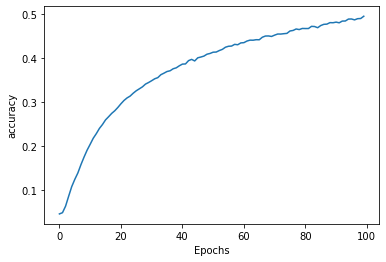

In [9]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [12]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=len_seq-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

im feeling chills on the middle of the line that life before you feel toys toys toys toys in the middle in the middle through the money men if spend place in this nights voulezvous of us last ease me this peaceful place of this nights men can move yeah yeah yeah yeah yeah yeah jack jeanie jeanie jeanie jeanie with someone so bad goin weak in the time baby you yet fly up and girl be a chance to the lot of a road star in the world where you ya ya ya ya flown wants this days well needs christmas out


# Varying the Possible Outputs
In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output?

Switching from model.predict_classes to model.predict_proba will get us all of the class probabilities. We can combine this with np.random.choice to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.



In [13]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=len_seq-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

17


In [17]:
# Use this process for the full output generation
seed_text = "Chutiya Kaliyaan We"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=len_seq-1, padding='pre')
    predicted_probs = model.predict(token_list)[0]
    predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Chutiya Kaliyaan We live in a dancing sea chill first town old fashioned paper true still shadows from cold fine unreal promises yeah forever sharing angels now talked laughter a little beginning singing whoever she get em sharing myself myself train wrong rikky told him easy more things shes goin round loud for insane in us apart between your heart from side side machine comin done by the trick to me weve done that whats the heat stays his new laughed will die twice the sunrise side of living side of love among too jump theyre happens she tasted did you surrender get
